## 任务1 Data Mining & 数据合并
##### 任务说明：基于Python的二手房数据爬虫程序，从房天下网站爬取**苏州桥、万柳、北太平庄、世纪城**四个指定区域的二手房房源和租房房源信息。

In [3]:
import time
import re
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service


#### 1.1 二手房信息采集
程序采用分区独立处理的策略，分别对每个区域进行多页遍历，通过自动化浏览器操作精准提取房源名称、面积、总价和单价等核心信息；并将四个区域的数据进行合并。此外，我们特别设计了基于房源名称和面积的双重校验机制，有效识别并剔除重复记录，进行初步的数据处理，确保数据质量。


In [4]:
#启动浏览器
driver = webdriver.Chrome()

#定义需要爬取的区域及对应网址模板
areas = {
    "苏州桥": "https://esf.fang.com/house-a015277-b02655/i3{}.html",
    "万柳": "https://esf.fang.com/house-a015277-b02313/i3{}.html",
    "北太平庄": "https://esf.fang.com/house-a015277-b05/i3{}.html",
    "世纪城": "https://esf.fang.com/house-a015277-b03115/i3{}.html"
}

# 存放所有区域合并数据
all_data_esf = []

# 存放每个区域独立 DataFrame
area_dfs_esf = {}

# 主循环：依次爬取每个区域 
for area_name, base_url in areas.items():
    print(f"\n开始爬取 {area_name} 区域的数据")

    area_data = []  # 当前区域的数据列表

    # 设置分页读取（每个区域最多爬取20页）
    for i in range(1, 21):
        url = base_url.format(i)
        driver.get(url)
        time.sleep(1.2)  # 控制页面加载时间，防止加载不全

        # 获取页面所有房源块
        houses = driver.find_elements(By.CSS_SELECTOR, "dl.clearfix")

        # 空页提前终止机制：如果当前页没有房源信息，则认为已到最后一页
        if not houses:
            print(f"第 {i} 页为空，提前结束 {area_name}。")
            break

        # 提取当前页的所有房源信息 
        for h in houses:
            try:
                # 房源名称
                try:
                    title = h.find_element(By.CSS_SELECTOR, "h4.clearfix a").text.strip() #取文字并去掉前后多余的空格和换行符
                except:
                    title = ""

                # 面积（提取“xx㎡”中的数字部分）
                try:
                    tel_info = h.find_element(By.CSS_SELECTOR, "p.tel_shop").text.strip()
                    match = re.search(r"(\d+\.?\d*)\s*(?:㎡|m²)", tel_info)
                    area = match.group(1) if match else ""
                except:
                    area = ""

                # 总价（单位：万）
                try:
                    total = h.find_element(By.CSS_SELECTOR, "dd.price_right span.red").text.strip()
                    total = re.sub(r"[^\d.]", "", total)  # 去除非数字字符
                except:
                    total = ""

                # 单价（单位：元/㎡）
                try:
                    unit = h.find_elements(By.CSS_SELECTOR, "dd.price_right span")[-1].text.strip()
                    unit = re.sub(r"[^\d.]", "", unit)
                except:
                    unit = ""

                #记录有效数据
                if title:
                    area_data.append({
                        "区域": area_name,
                        "房源名称": title,
                        "面积(㎡)": area,
                        "总价(万)": total,
                        "单价(元/㎡)": unit
                    })
            except Exception:
                # 单条数据提取失败时跳过，不影响其他房源
                continue

        # 当前页完成提示
        print(f"{area_name} 第 {i} 页抓取完成，累计 {len(area_data)} 条。")

    # 当前区域数据处理与保存 
    df_area = pd.DataFrame(area_data)
    df_area.drop_duplicates(subset=["房源名称", "面积(㎡)"], inplace=True)

    # 保存当前区域 CSV 文件
    #save_path_area = fr"C:\Users\Lenovo\Desktop\esf_{area_name}.csv"
    #df_area.to_csv(save_path_area, index=False, encoding="utf-8-sig")
    print(f"{area_name} 区域数据保存完成，共 {len(df_area)} 条")

    # 保存 DataFrame 到字典
    area_dfs_esf[area_name] = df_area

    # 将当前区域数据加入总表
    all_data_esf.extend(area_data)

# 关闭浏览器
driver.quit()

# 保存所有区域合并结果
df_all_esf = pd.DataFrame(all_data_esf)
df_all_esf.drop_duplicates(subset=["区域", "房源名称", "面积(㎡)"], inplace=True) #去重，要求房源名称和面积双重检验

save_path_all = r"C:\Users\Lenovo\Desktop\esf_all.csv"
df_all_esf.to_csv(save_path_all, index=False, encoding="utf-8-sig")

print(f"\n全部区域爬取完成，共 {len(df_all_esf)} 条数据，文件已保存：{save_path_all}")



There was an error managing chromedriver (error decoding response body); using driver found in the cache



开始爬取 苏州桥 区域的数据
苏州桥 第 1 页抓取完成，累计 60 条。
苏州桥 第 2 页抓取完成，累计 120 条。
苏州桥 第 3 页抓取完成，累计 180 条。
苏州桥 第 4 页抓取完成，累计 240 条。
苏州桥 第 5 页抓取完成，累计 300 条。
苏州桥 第 6 页抓取完成，累计 309 条。
第 7 页为空，提前结束 苏州桥。
苏州桥 区域数据保存完成，共 205 条

开始爬取 万柳 区域的数据
万柳 第 1 页抓取完成，累计 60 条。
万柳 第 2 页抓取完成，累计 120 条。
万柳 第 3 页抓取完成，累计 180 条。
万柳 第 4 页抓取完成，累计 240 条。
万柳 第 5 页抓取完成，累计 300 条。
万柳 第 6 页抓取完成，累计 360 条。
万柳 第 7 页抓取完成，累计 420 条。
万柳 第 8 页抓取完成，累计 480 条。
万柳 第 9 页抓取完成，累计 540 条。
万柳 第 10 页抓取完成，累计 600 条。
万柳 第 11 页抓取完成，累计 660 条。
万柳 第 12 页抓取完成，累计 720 条。
万柳 第 13 页抓取完成，累计 780 条。
万柳 第 14 页抓取完成，累计 840 条。
万柳 第 15 页抓取完成，累计 900 条。
万柳 第 16 页抓取完成，累计 960 条。
万柳 第 17 页抓取完成，累计 1020 条。
万柳 第 18 页抓取完成，累计 1080 条。
万柳 第 19 页抓取完成，累计 1140 条。
万柳 第 20 页抓取完成，累计 1200 条。
万柳 区域数据保存完成，共 398 条

开始爬取 北太平庄 区域的数据
北太平庄 第 1 页抓取完成，累计 60 条。
北太平庄 第 2 页抓取完成，累计 120 条。
北太平庄 第 3 页抓取完成，累计 180 条。
北太平庄 第 4 页抓取完成，累计 198 条。
第 5 页为空，提前结束 北太平庄。
北太平庄 区域数据保存完成，共 136 条

开始爬取 世纪城 区域的数据
世纪城 第 1 页抓取完成，累计 60 条。
世纪城 第 2 页抓取完成，累计 120 条。
世纪城 第 3 页抓取完成，累计 180 条。
世纪城 第 4 页抓取完成，累计 240 条。
世纪城 第 5 页抓取完成，累计 300 条。
世

In [5]:

print(df_all_esf)

       区域                            房源名称   面积(㎡) 总价(万) 单价(元/㎡)
0     苏州桥    苏州桥·友谊宾馆家属院不临街中间层正规三居室三条地铁环抱   91.28   720   78878
1     苏州桥              苏州桥·三义庙·理工北门楼层南北两居    56.7   398   70194
2     苏州桥         紫金庄园 254平4居 东西向简装修 拎包入住     254  1255   49409
3     苏州桥             苏州桥人民大学南侧三线地铁南北通透明厅    58.7   480   81771
5     苏州桥     北三环 中关村 友谊宾馆 理工大学 人民大学 业主急售      57   355   62280
...   ...                             ...     ...   ...     ...
2885  世纪城       世纪城 10号线 12号线 两个洗衣晾衣阳台 金源  156.47  1260   80526
2886  世纪城   世纪城 10号线 12号线 洗衣晾衣阳台 衣帽间 双卧朝南     135  1470  108888
2891  世纪城       翠叠园大四居,三卧南全天铺满阳光,客厅面宽4.8米  201.25  2280  113291
2896  世纪城  世纪城 10号线 12号线 2个洗衣晾衣阳台 双卧朝南 金源     164  1750  106707
2903  世纪城        洋房三居室 双明卫 双卧朝南 全明户型 南北通透  122.68  1400  114118

[1073 rows x 5 columns]


#### 1.2 租房信息采集 
方法同上，提取核心租赁特征变量，包括房源名称、建筑面积与月租金。

In [6]:
# 启动浏览器
driver = webdriver.Chrome()

# 定义区域及其对应网址
areas = {
    "苏州桥": "https://zu.fang.com/house-a015277-b02655/i3{}.html",
    "万柳": "https://zu.fang.com/house-a015277-b02313/i3{}.html",
    "北太平庄": "https://zu.fang.com/house-a015277-b05/i3{}.html",
    "世纪城": "https://zu.fang.com/house-a015277-b03115/i3{}.html"
}

# 用于分别存放各区域的 DataFrame
area_dfs_rent = {}
all_data_rent = []  # 存储合并数据

#主循环：依次爬取每个区域 
for area_name, base_url in areas.items():
    print(f"\n开始爬取 {area_name} 区域的数据")

    area_data = []  # 当前区域的数据列表

    # 设置分页（最多20页）
    for i in range(1, 21):
        url = base_url.format(i)
        driver.get(url)
        time.sleep(1.2)  # 页面加载延时

        # 每页所有房源块
        houses = driver.find_elements(By.CSS_SELECTOR, "dl.list.hiddenMap.rel")

        # 空页提前结束机制
        if not houses:
            print(f"第 {i} 页为空，提前结束 {area_name}。")
            break

        # 提取每条房源信息
        for h in houses:
            try:
                # 房源名称
                try:
                    title = h.find_element(By.CSS_SELECTOR, "p.title a").text.strip()
                except:
                    title = ""

                # 面积
                try:
                    tel_info = h.find_element(By.CSS_SELECTOR, "p.font15.mt12.bold").text.strip()
                    match = re.search(r"(\d+\.?\d*)\s*(?:㎡|m²)", tel_info)
                    area_size = match.group(1) if match else ""
                except:
                    area_size = ""

                # 月租金
                try:
                    total_price = h.find_element(By.CSS_SELECTOR, "span.price").text.strip()
                except:
                    total_price = ""

                # 记录有效数据
                if title:
                    area_data.append({
                        "区域": area_name,
                        "房源名称": title,
                        "面积(㎡)": area_size,
                        "总价(元/月)": total_price
                    })
            except:
                continue

        print(f"{area_name} 第 {i} 页抓取完成，共 {len(area_data)} 条。")

    # 当前区域数据转 DataFrame 并去重
    df_area = pd.DataFrame(area_data)
    df_area.drop_duplicates(subset=["房源名称", "面积(㎡)"], inplace=True)

    # 保存单区域 CSV
    #save_path = fr"C:\Users\Lenovo\Desktop\rent_{area_name}.csv"
    #df_area.to_csv(save_path, index=False, encoding="utf-8-sig")
    print(f"{area_name} 区域数据保存完成，共 {len(df_area)} 条")

    # 存入字典和总数据
    area_dfs_rent[area_name] = df_area
    all_data_rent.extend(area_data)

# 关闭浏览器
driver.quit()

# 合并所有区域数据 
df_all_rent = pd.DataFrame(all_data_rent)
df_all_rent.drop_duplicates(subset=["区域", "房源名称", "面积(㎡)"], inplace=True)#去重，要求房源名称和面积双重检验
save_path_all = r"C:\Users\Lenovo\Desktop\rent_all.csv"
df_all_rent.to_csv(save_path_all, index=False, encoding="utf-8-sig")

print(f"\n全部区域数据爬取完成，共 {len(df_all_rent)} 条，合并文件已保存：{save_path_all}")


There was an error managing chromedriver (error decoding response body); using driver found in the cache



开始爬取 苏州桥 区域的数据
苏州桥 第 1 页抓取完成，共 60 条。
苏州桥 第 2 页抓取完成，共 120 条。
苏州桥 第 3 页抓取完成，共 180 条。
苏州桥 第 4 页抓取完成，共 240 条。
苏州桥 第 5 页抓取完成，共 288 条。
第 6 页为空，提前结束 苏州桥。
苏州桥 区域数据保存完成，共 177 条

开始爬取 万柳 区域的数据
万柳 第 1 页抓取完成，共 60 条。
万柳 第 2 页抓取完成，共 120 条。
万柳 第 3 页抓取完成，共 180 条。
万柳 第 4 页抓取完成，共 240 条。
万柳 第 5 页抓取完成，共 300 条。
万柳 第 6 页抓取完成，共 360 条。
万柳 第 7 页抓取完成，共 420 条。
万柳 第 8 页抓取完成，共 480 条。
万柳 第 9 页抓取完成，共 540 条。
万柳 第 10 页抓取完成，共 600 条。
万柳 第 11 页抓取完成，共 660 条。
万柳 第 12 页抓取完成，共 720 条。
万柳 第 13 页抓取完成，共 780 条。
万柳 第 14 页抓取完成，共 840 条。
万柳 第 15 页抓取完成，共 900 条。
万柳 第 16 页抓取完成，共 960 条。
万柳 第 17 页抓取完成，共 1020 条。
万柳 第 18 页抓取完成，共 1080 条。
万柳 第 19 页抓取完成，共 1140 条。
万柳 第 20 页抓取完成，共 1200 条。
万柳 区域数据保存完成，共 205 条

开始爬取 北太平庄 区域的数据
北太平庄 第 1 页抓取完成，共 60 条。
北太平庄 第 2 页抓取完成，共 120 条。
北太平庄 第 3 页抓取完成，共 180 条。
北太平庄 第 4 页抓取完成，共 233 条。
第 5 页为空，提前结束 北太平庄。
北太平庄 区域数据保存完成，共 153 条

开始爬取 世纪城 区域的数据
世纪城 第 1 页抓取完成，共 60 条。
世纪城 第 2 页抓取完成，共 120 条。
世纪城 第 3 页抓取完成，共 180 条。
世纪城 第 4 页抓取完成，共 240 条。
世纪城 第 5 页抓取完成，共 300 条。
世纪城 第 6 页抓取完成，共 360 条。
世纪城 第 7 页抓取完成，共 420 条。
世纪城 第 8 页抓取完成

In [7]:
print(df_all_rent)

       区域                        房源名称 面积(㎡) 总价(元/月)
0     苏州桥  可短签可月付·苏州桥·海淀区北三环西路47号·2室·    57    6000
1     苏州桥     苏州桥·海淀区北三环西路47号·中楼层·2居室    54    6700
2     苏州桥  可短签可月付北京大学新东方海淀黄庄经典通透三居随时看    85   12500
3     苏州桥   可短签可月付北三环人民大学友谊社区通透2居随时看房    62    6500
4     苏州桥         整租·苏州桥·人民大学静园·3室·1厅    74   15000
...   ...                         ...   ...     ...
2847  世纪城     世纪城晴波园239平南北通透5居 精装电梯高层   239   32000
2848  世纪城               海淀四环内,不临街随时看房   138   13500
2880  世纪城      海淀世纪城精装两居 东南向低层 月租9500    98    9200
2903  世纪城    远大园六区 豪华装修 南北通透 视野开阔 采光好   135   14500
2910  世纪城              中式古典装修,柔光暖色随时看   180   18500

[699 rows x 4 columns]


## 任务2 Data Research

##### 2.1 任务介绍：数据预处理& 离群值检验&描述性统计
- **数据预处理**：重复数据已在上一步剔除完毕，这一步检查数据是否有缺失值，然对于二手房数据，只保留区域，面积(㎡)和单价(元/㎡)；对于租房数据，保留区域和面积，计算后rent_per_m2，同时只保留这三项数据。
- **离群值检验(IQR)**：
    - 记 Q1 为 25% 分位数，Q3 为 75% 分位数，IQR = Q3 - Q1；
    - **判定规则**：小于 `Q1 - 1.5×IQR` 或大于 `Q3 + 1.5×IQR` 的观测记为离群值；
    - 输出阈值、剔除数量，并在剔除后保留清洗后的数据（供后续分析与建模）
-  **描述性统计**：对各区域和总体数据进行描述性统计

#### 2.1数据预处理：
    重复数据已在上一步剔除完毕，现检查数据是否有缺失值。对于二手房数据，只保留区域，面积(㎡)和单价(元/㎡)；对于租房数据，保留区域和面积，计算后rent_per_m2，同时只保留这三项数据。

In [14]:
def report_missing(df, name):
    print(f"[缺失值检查] {name}")
    display(df.isna().sum().to_frame('n_missing'))
report_missing(df_all_esf, 'esf')
report_missing(df_all_rent, 'rent')

[缺失值检查] esf


,n_missing
区域,0
房源名称,0
面积(㎡),0
总价(万),0
单价(元/㎡),0


[缺失值检查] rent


,n_missing
区域,0
房源名称,0
面积(㎡),0
总价(元/月),0


In [22]:
def prepare_esf(df):
    """提取出售数据必要列。"""
    return df[['区域', '面积(㎡)', '单价(元/㎡)']].rename(
        columns={'区域': 'block', '面积(㎡)': 'area_m2', '单价(元/㎡)': 'price_per_m2'}
    )
    # 转换为数值类型（防止是字符串）
    out['area_m2'] = pd.to_numeric(out['area_m2'], errors='coerce')
    out['price_per_m2'] = pd.to_numeric(out['price_per_m2'], errors='coerce')

def prepare_rent(df):
    """提取出租数据并计算每平米租金。"""
    out = df[['区域', '面积(㎡)', '总价(元/月)']].rename(
        columns={'区域': 'block','面积(㎡)': 'area_m2','总价(元/月)': 'rent_monthly'}
    )
    # 转换为数值类型
    out['area_m2'] = pd.to_numeric(out['area_m2'], errors='coerce')
    out['rent_monthly'] = pd.to_numeric(out['rent_monthly'], errors='coerce')
    #计算rent_per_m2
    out['rent_per_m2'] = out['rent_monthly'] / out['area_m2']
    return out[['block', 'area_m2', 'rent_per_m2']]
esf_base = prepare_esf(df_all_esf)
rent_base = prepare_rent(df_all_rent)

display(esf_base.head())
display(rent_base.head())


,block,area_m2,price_per_m2
0,苏州桥,91.28,78878
1,苏州桥,56.7,70194
2,苏州桥,254,49409
3,苏州桥,58.7,81771
5,苏州桥,57,62280


,block,area_m2,rent_per_m2
0,苏州桥,57,105.263158
1,苏州桥,54,124.074074
2,苏州桥,85,147.058824
3,苏州桥,62,104.838710
4,苏州桥,74,202.702703


#### 2.2 Outlier Detection & Data Description for each block
##### 离群值检验方法：
- 记 Q1 为 25% 分位数，Q3 为 75% 分位数，IQR = Q3 - Q1；
- **判定规则**：小于 `Q1 - 1.5×IQR` 或大于 `Q3 + 1.5×IQR` 的观测记为离群值；
- 输出阈值、剔除数量，并在剔除后保留清洗后的数据（供后续分析与建模）

In [ ]:
def iqr_bounds(s):
    """
    计算IQR离群值上下限。
    Q1 = 25%分位数，Q3 = 75%分位数
    离群值定义：小于 Q1 - 1.5×IQR 或 大于 Q3 + 1.5×IQR
    """
    s = pd.to_numeric(s, errors="coerce")
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    return q1 - 1.5 * iqr, q3 + 1.5 * iqr

def drop_outliers_by_block(df, cols, name):
    """
    按区域分组的IQR方法剔除离群值，并生成各区域统计。
    """
    df = df.copy()
    total_before = len(df)
    cleaned_blocks = []
    summary = []

    print(f"\n[{name}] 分区域离群值检测与剔除：")

    for block, group in df.groupby("block"):
        mask = pd.Series(True, index=group.index)
        for col in cols:
            group[col] = pd.to_numeric(group[col], errors="coerce")
            lb, ub = iqr_bounds(group[col])
            outlier_mask = ~group[col].between(lb, ub)
            n_outliers = outlier_mask.sum()
            summary.append({
                "block": block,
                "column": col,
                "lower": lb,
                "upper": ub,
                "outliers": int(n_outliers),
                "rows_before": len(group),
                "rows_after": len(group) - int(n_outliers)
            })
            mask &= ~outlier_mask
        cleaned_blocks.append(group[mask])

    cleaned = pd.concat(cleaned_blocks, ignore_index=True)
    total_after = len(cleaned)
    print(f"  → 共删除 {total_before - total_after} 行，剩余 {total_after} 行数据。")

    summary_df = pd.DataFrame(summary)
    print("\n各区域离群值剔除统计：")
    display(summary_df)

    # === 分区域描述性统计 ===
    print("\n各区域描述性统计（去除离群值后）：")
    desc = cleaned.groupby("block")[cols].describe().round(2)
    display(desc)

    return cleaned, summary_df, desc


esf_clean, esf_summary, esf_desc = drop_outliers_by_block(esf_base, ['area_m2', 'price_per_m2'], 'ESF（出售）')
rent_clean, rent_summary, rent_desc = drop_outliers_by_block(rent_base, ['area_m2', 'rent_per_m2'], 'RENT（出租）')




[ESF（出售）] 分区域离群值检测与剔除：
  → 共删除 88 行，剩余 985 行数据。

各区域离群值剔除统计：


,block,column,lower,upper,outliers,rows_before,rows_after
0,万柳,area_m2,-83.17500,473.40500,4,398,394
1,万柳,price_per_m2,49200.75000,257730.75000,17,398,381
2,世纪城,area_m2,31.43125,291.38125,15,334,319
3,世纪城,price_per_m2,61269.50000,164165.50000,4,334,330
4,北太平庄,area_m2,-38.77625,263.29375,12,136,124
5,北太平庄,price_per_m2,40163.75000,137207.75000,10,136,126
6,苏州桥,area_m2,3.08000,144.20000,24,205,181
7,苏州桥,price_per_m2,45460.50000,111416.50000,4,205,201



各区域描述性统计（去除离群值后）：


area_m2                                                        \
        count    mean    std    min     25%     50%     75%     max   
block                                                                 
万柳      378.0  186.69  99.32  44.17  121.49  158.30  238.50  464.87   
世纪城     316.0  157.97  43.74  56.99  126.92  163.70  181.85  283.00   
北太平庄    114.0  111.53  47.91  26.50   74.90   95.15  144.85  216.80   
苏州桥     177.0   68.14  20.51  26.80   54.40   63.45   81.36  127.20   

      price_per_m2                                                     \
             count       mean       std      min        25%       50%   
block                                                                   
万柳           378.0  153792.35  42854.64  61626.0  126029.25  142343.5   
世纪城          316.0  110909.64  16761.17  65998.0   99378.50  108809.5   
北太平庄         114.0   92358.33  16730.61  40499.0   80466.50   91518.0   
苏州桥          177.0   80476.39  10851.46  53522.0   72476.00   80669.0   

                           
            75%       max  
block                      
万柳     173083.0  254115.0  
世纪城    124255.0  153992.0  
北太平庄   103640.0  126552.0  
苏州桥     86683.0  108747.0


[RENT（出租）] 分区域离群值检测与剔除：
  → 共删除 62 行，剩余 637 行数据。

各区域离群值剔除统计：


,block,column,lower,upper,outliers,rows_before,rows_after
0,万柳,area_m2,-202.500000,601.500000,0,205,205
1,万柳,rent_per_m2,44.904692,301.502933,17,205,188
2,世纪城,area_m2,46.375000,253.375000,6,164,158
3,世纪城,rent_per_m2,52.261959,178.988689,6,164,158
4,北太平庄,area_m2,2.000000,130.000000,14,153,139
5,北太平庄,rent_per_m2,58.682927,214.390244,4,153,149
6,苏州桥,area_m2,16.500000,116.500000,11,177,166
7,苏州桥,rent_per_m2,45.959596,219.696970,9,177,168



各区域描述性统计（去除离群值后）：


area_m2                                                    rent_per_m2  \
        count    mean     std   min     25%    50%    75%    max       count   
block                                                                          
万柳      188.0  193.18  117.87  42.0   98.00  159.0  298.5  468.0       188.0   
世纪城     154.0  147.91   42.31  57.0  123.25  145.0  172.0  239.0       154.0   
北太平庄    135.0   60.21   25.97  10.0   48.50   56.0   74.5  130.0       135.0   
苏州桥     160.0   64.36   18.02  18.0   56.00   62.0   75.5  113.0       160.0   

                                                              
         mean    std     min     25%     50%     75%     max  
block                                                         
万柳     165.10  40.91  104.97  137.63  150.42  188.68  298.17  
世纪城    114.43  19.11   79.75   99.14  110.27  126.84  171.55  
北太平庄   139.68  29.13   88.50  117.41  132.47  156.75  213.33  
苏州桥    131.44  30.61   48.21  111.11  125.00  149.60  215.38

##### 2.3 计算每区域的median price to rent ratio ，并绘制柱状图


In [26]:
# 计算每个区域的中位房价 & 中位租金单价
median_price = esf_clean.groupby('block')['price_per_m2'].median()
median_rent  = rent_clean.groupby('block')['rent_per_m2'].median()
# 计算每区域房价租金比
median_ratio = (median_price / median_rent).dropna().sort_values(ascending=False)


In [55]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
import numpy as np
def plot_bar(series, title, xlabel, ylabel, hline=None, figsize=(8, 6)):
    """
    绘制带标签的柱状图，适用于中位数价格/租金比等指标。

    参数：
    ----------
    series : pd.Series
        要绘制的数据（索引为类别名，值为数值）
    title : str
        图标题
    xlabel : str
        x轴标签
    ylabel : str
        y轴标签
    hline : float, optional
        可选参数，在图上添加参考水平线
    figsize : tuple, default=(8, 6)
        图像尺寸（宽, 高）
    """

    # 字体设置：中英混合显示无乱码
    rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial']
    rcParams['font.family'] = ['sans-serif']
    rcParams['axes.unicode_minus'] = False

    # 绘图主体
    plt.figure(figsize=figsize)
    ax = series.dropna().plot(kind='bar', color='tab:blue')

    # 添加参考线（如果给定）
    if hline is not None:
        plt.axhline(hline, linestyle='--', color='tab:orange', alpha=0.7)

    # 标签与标题
    plt.title(title, fontsize=22, pad=15)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.xticks(rotation=0, fontsize=16)
    plt.yticks(fontsize=16)

    # 在柱上显示数值
    for p in ax.patches:
        ax.annotate(
            f'{p.get_height():.0f}',
            (p.get_x() + p.get_width() / 2, p.get_height()),
            ha='center', va='bottom',
            fontsize=14, fontweight='bold'
        )

    plt.grid(axis='y', linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()


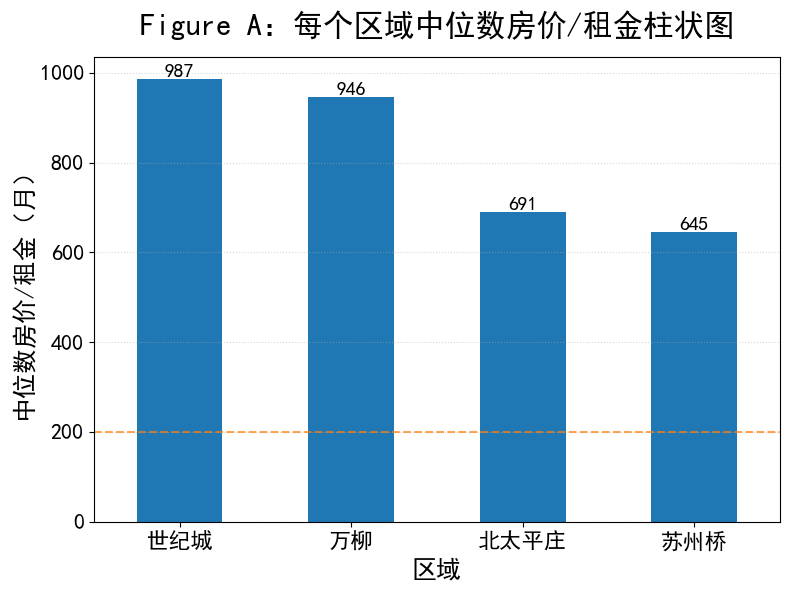

,median_price_per_m2,median_rent_per_m2,median_ratio
block,,,
万柳,142343.5,150.417452,946.323036
世纪城,108809.5,110.265169,986.798469
北太平庄,91518.0,132.470588,690.855240
苏州桥,80669.0,125.000000,645.352000


In [66]:
plot_bar(
    series=median_ratio, 
    title='Figure A：每个区域中位数房价/租金柱状图',
    xlabel='区域', 
    ylabel='中位数房价/租金（月）',
    hline=200,             # 参考线（可选）
    figsize=(8, 6)         # 宽 × 高
)
display(pd.DataFrame({
    'median_price_per_m2': median_price,
    'median_rent_per_m2': median_rent,
    'median_ratio': median_ratio
}).dropna())

## 任务3 Modeling（model-1&2）

为进一步比较不同区域的房价与租金水平，基于清洗后的 `esf_clean`（出售）与 `rent_clean`（出租）数据，建立了两个线性回归模型：
$$
\text{Model 1: } \text{price\_per\_m2} = \beta_0 + \beta_1 \times \text{area\_m2} + \beta_2 \times \text{block}
$$

$$
\text{Model 2: } \text{rent\_per\_m2} = \beta_0 + \beta_1 \times \text{area\_m2} + \beta_2 \times \text{block}
$$
其中，`block` 表示区域（作为分类变量），模型采用普通最小二乘法（OLS）拟合。  
基于模型预测结果，分别计算各区域的**中位数房价**与**中位数租金**，并得到**预测房价租金比**：

$$
\text{Predicted Ratio} = \frac{\text{Median Predicted Price}}{\text{Median Predicted Rent}}
$$
最后通过柱状图（Figure B）展示各区域的预测房价/租金比。

Model 1 (Price per m²) Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           price_per_m2   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     465.1
Date:                Mon, 20 Oct 2025   Prob (F-statistic):          1.11e-224
Time:                        23:23:37   Log-Likelihood:                -11335.
No. Observations:                 985   AIC:                         2.268e+04
Df Residuals:                     980   BIC:                         2.270e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1.095e+05   2429.448     45.059      0.000    1.05e+05    1.14e+05
C(block)[T.世纪城]  -3.606e+04   1867.477    -19.311      0.000   -3.97e+04   -3.24e+04
C(block)[T.北太平庄] -4.359e+04   2712.413    -16.071      0.000   -4.89e+04   -3.83e+04
C(block)[T.苏州桥]  -4.517e+04   2567.168    -17.595      0.000   -5.02e+04   -4.01e+04
area_m2            237.4239     11.186     21.224      0.000     215.472     259.376
==============================================================================
Omnibus:                      133.465   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              380.557
Skew:                           0.691   Prob(JB):                     2.31e-83
Kurtosis:                       5.713   Cond. No.                         835.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Model 2 (Rent per m²) Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            rent_per_m2   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     81.92
Date:                Mon, 20 Oct 2025   Prob (F-statistic):           5.15e-56
Time:                        23:23:37   Log-Likelihood:                -3067.2
No. Observations:                 637   AIC:                             6144.
Df Residuals:                     632   BIC:                             6167.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          136.9587      3.987     34.353      0.000     129.130     144.788
C(block)[T.世纪城]    -44.0803      3.349    -13.161      0.000     -50.658     -37.503
C(block)[T.北太平庄]    -6.0479      4.086     -1.480      0.139     -14.072       1.976
C(block)[T.苏州桥]    -14.8938      3.916     -3.804      0.000     -22.583      -7.204
area_m2              0.1457      0.017      8.440      0.000       0.112       0.180
==============================================================================
Omnibus:                       55.658   Durbin-Watson:                   1.840
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.446
Skew:                           0.685   Prob(JB):                     6.83e-17
Kurtosis:                       3.964   Cond. No.                         838.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

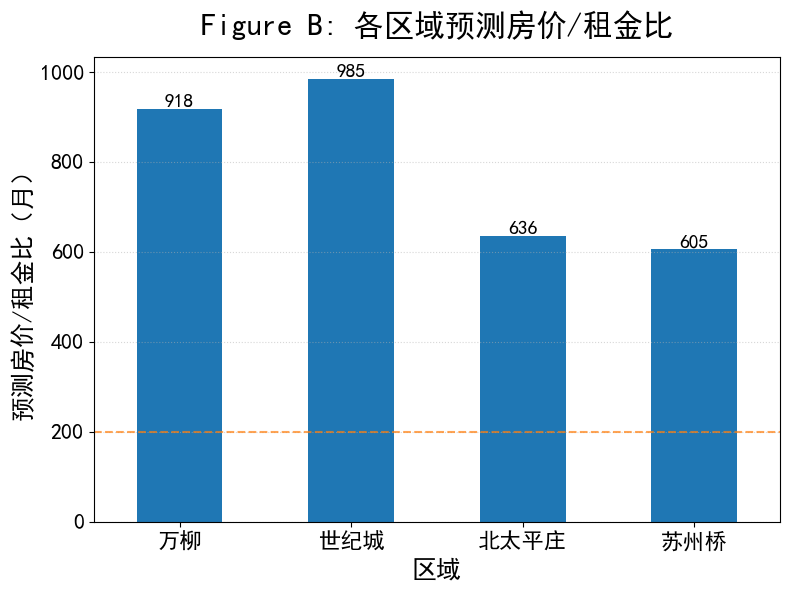

,median_pred_price,median_pred_rent,median_pred_ratio
block,,,
万柳,147052.451033,160.122263,918.376047
世纪城,112270.067297,114.002354,984.804815
北太平庄,88468.393259,139.069033,636.147324
苏州桥,79362.576810,131.097201,605.372017


In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# 出售模型
model_esf = smf.ols('price_per_m2 ~ area_m2 + C(block)', data=esf_clean).fit()

# 出租模型
model_rent = smf.ols('rent_per_m2 ~ area_m2 + C(block)', data=rent_clean).fit()

print("Model 1 (Price per m²) Summary:")
display(model_esf.summary())

print("Model 2 (Rent per m²) Summary:")
display(model_rent.summary())

# 为所有数据预测
esf_clean['pred_price'] = model_esf.predict(esf_clean)
rent_clean['pred_rent'] = model_rent.predict(rent_clean)

#  按区域计算预测中位数

median_price_pred = esf_clean.groupby('block')['pred_price'].median()
median_rent_pred = rent_clean.groupby('block')['pred_rent'].median()
median_ratio_pred = median_price_pred / median_rent_pred

#绘制 Figure B
plot_bar(
    median_ratio_pred,                         # 数据
    title='Figure B: 各区域预测房价/租金比',     # 图表标题
    xlabel='区域',                              # x 轴标签
    ylabel='预测房价/租金比（月）',              # y 轴标签
    hline=200,                                  # 添加参考线（国际标准值）
    figsize=(8, 6)                              # 图像大小
)
display(pd.DataFrame({
    'median_pred_price': median_price_pred,
    'median_pred_rent': median_rent_pred,
    'median_pred_ratio': median_ratio_pred
}).dropna())


## 任务四：Modeling Pro Max

为了提升模型的预测能力，我们为模型 1 和模型 2 添加了**非线性特征**和**交互项**，构建了 Model 1+ 和 Model 2+。通过比较这些模型的 **R²** 值，来评估哪种模型拟合效果更好。

### **模型设定**

- **Model 1**: `price_per_m2 ~ area_m2 + C(block)`  
- **Model 1+**: `price_per_m2 ~ area_m2 + C(block) + area_m2^2 + area_m2 * C(block)`
  
- **Model 2**: `rent_per_m2 ~ area_m2 + C(block)`  
- **Model 2+**: `rent_per_m2 ~ area_m2 + C(block) + area_m2^2 + area_m2 * C(block)`

在模型中，`area_m2^2` 和 `area_m2 * C(block)` 是加入的非线性和交互项。通过比较 **Model 1** 和 **Model 1+**，以及 **Model 2** 和 **Model 2+** 的 **R²** 值，我们可以分析哪个模型对数据的拟合效果更好。

Model 1+ (Price per m² with non-linearity & interaction):


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           price_per_m2   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     253.9
Date:                Mon, 20 Oct 2025   Prob (F-statistic):          1.89e-232
Time:                        23:26:39   Log-Likelihood:                -11305.
No. Observations:                 985   AIC:                         2.263e+04
Df Residuals:                     976   BIC:                         2.267e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 1.059e+05   5034.915     21.037      0.000     9.6e+04    1.16e+05
C(block)[T.世纪城]            833.6645   5841.038      0.143      0.887   -1.06e+04    1.23e+04
C(block)[T.北太平庄]         -2.653e+04   6778.300     -3.914      0.000   -3.98e+04   -1.32e+04
C(block)[T.苏州桥]          -3.326e+04   7628.250     -4.360      0.000   -4.82e+04   -1.83e+04
area_m2                    230.9772     50.916      4.536      0.000     131.061     330.894
area_m2:C(block)[T.世纪城]   -222.7521     35.583     -6.260      0.000    -292.580    -152.924
area_m2:C(block)[T.北太平庄]  -128.7710     52.349     -2.460      0.014    -231.501     -26.041
area_m2:C(block)[T.苏州桥]   -124.2529     92.963     -1.337      0.182    -306.683      58.177
I(area_m2 ** 2)              0.1063      0.110      0.969      0.333      -0.109       0.322
==============================================================================
Omnibus:                      151.171   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              576.371
Skew:                           0.689   Prob(JB):                    6.96e-126
Kurtosis:                       6.485   Cond. No.                     5.66e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.66e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Model 2+ (Rent per m² with non-linearity & interaction):


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            rent_per_m2   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     53.40
Date:                Mon, 20 Oct 2025   Prob (F-statistic):           6.00e-66
Time:                        23:26:39   Log-Likelihood:                -3035.0
No. Observations:                 637   AIC:                             6088.
Df Residuals:                     628   BIC:                             6128.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  120.7740      7.440     16.234      0.000     106.164     135.384
C(block)[T.世纪城]            -20.9500      9.692     -2.162      0.031     -39.983      -1.917
C(block)[T.北太平庄]            46.3280      9.286      4.989      0.000      28.092      64.564
C(block)[T.苏州桥]             32.5847     10.832      3.008      0.003      11.313      53.856
area_m2                      0.2921      0.081      3.624      0.000       0.134       0.450
area_m2:C(block)[T.世纪城]     -0.1555      0.063     -2.457      0.014      -0.280      -0.031
area_m2:C(block)[T.北太平庄]    -0.7306      0.111     -6.565      0.000      -0.949      -0.512
area_m2:C(block)[T.苏州桥]     -0.6162      0.138     -4.450      0.000      -0.888      -0.344
I(area_m2 ** 2)             -0.0002      0.000     -1.356      0.176      -0.001       0.000
==============================================================================
Omnibus:                       51.051   Durbin-Watson:                   1.844
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.846
Skew:                           0.605   Prob(JB):                     9.22e-17
Kurtosis:                       4.148   Cond. No.                     5.52e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.52e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

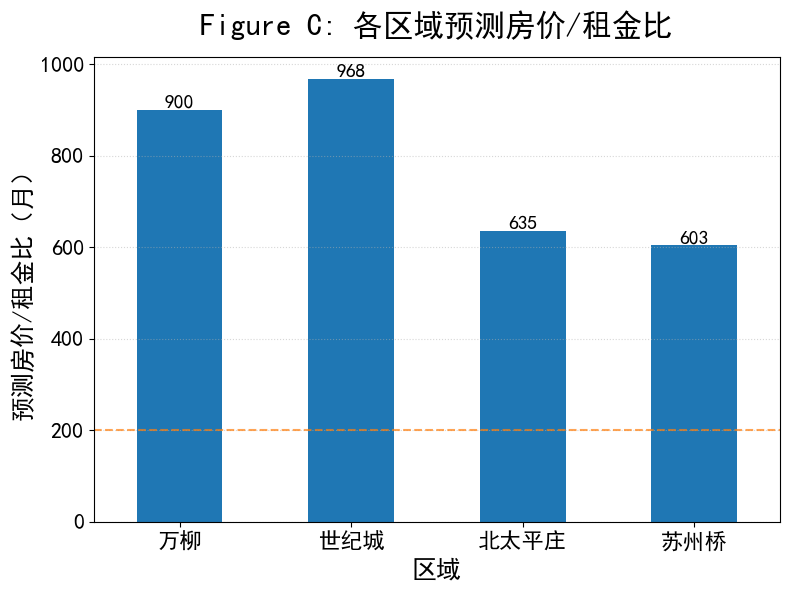

,median_pred_price,median_pred_rent,median_pred_ratio
block,,,
万柳,145148.922288,161.234848,900.232948
世纪城,110949.938399,114.650917,967.719590
北太平庄,90082.048124,141.805439,635.251009
苏州桥,79865.642879,132.354034,603.424319


In [68]:
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd

# 1. 模型训练与拟合（包括非线性与交互项）
# 模型 1+ 和 模型 2+，包括非线性特征和交互项、

# Model 1+: price_per_m2 = β0 + β1 * area_m2 + β2 * block + β3 * area_m2^2 + β4 * area_m2:block
model_esf_plus = smf.ols('price_per_m2 ~ area_m2 + C(block) + I(area_m2 ** 2) + area_m2:C(block)', data=esf_clean).fit()

# Model 2+: rent_per_m2 = β0 + β1 * area_m2 + β2 * block + β3 * area_m2^2 + β4 * area_m2:block
model_rent_plus = smf.ols('rent_per_m2 ~ area_m2 + C(block) + I(area_m2 ** 2) + area_m2:C(block)', data=rent_clean).fit()


print("Model 1+ (Price per m² with non-linearity & interaction):")
display(model_esf_plus.summary())

print("Model 2+ (Rent per m² with non-linearity & interaction):")
display(model_rent_plus.summary())

# 3. 使用模型预测房价与租金
esf_clean['pred_price'] = model_esf_plus.predict(esf_clean)  # 使用 Model 1+
rent_clean['pred_rent'] = model_rent_plus.predict(rent_clean)  # 使用 Model 2+

# 计算每个区域的中位数预测房价和租金
median_price_pred = esf_clean.groupby('block')['pred_price'].median()
median_rent_pred = rent_clean.groupby('block')['pred_rent'].median()

# 计算每个区域的预测房价租金比
median_ratio_pred = median_price_pred / median_rent_pred

# 4. 绘制图表（调用画图函数）
plot_bar(
    median_ratio_pred,                         # 数据
    title='Figure C: 各区域预测房价/租金比',     # 图表标题
    xlabel='区域',                              # x 轴标签
    ylabel='预测房价/租金比（月）',              # y 轴标签
    hline=200,                                  # 添加参考线（国际标准值）
    figsize=(8, 6)                              # 图像大小
)

# 5. 输出结果表格
display(pd.DataFrame({
    'median_pred_price': median_price_pred,
    'median_pred_rent': median_rent_pred,
    'median_pred_ratio': median_ratio_pred
}).dropna())


### 结果比较与分析

| 方法   | 模型类型           | 数据来源 | R²（价格） | R²（租金） | 优点             | 缺点             |
|--------|--------------------|----------|------------|------------|------------------|------------------|
| 方法一 | 实际统计           | 原始数据 | —          | —          | 真实反映市场     | 样本量较小       |
| 方法二 | 线性模型           | 模型预测 | 0.655      | 0.341      | 解释性强         | 拟合不完全，未考虑非线性 |
| 方法三 | 非线性交互模型     | 模型预测 | 0.675      | 0.405      | 拟合度高，捕捉复杂关系 | 样本量较小，可能过拟合 |
